In [261]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [262]:
data = pd.read_csv('Walmart_Store_sales.csv', parse_dates=['Date'] , infer_datetime_format=True)

In [263]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,2012-07-27,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaT,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092


### Part 1 : EDA and data preprocessing

In [264]:
print(f"Shape of data set : {data.shape}")
print(data.columns)
display(data.describe(include='all'))
display(data.head())
data.isna().sum()

Shape of data set : (150, 8)
Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')


C:\Users\Celine\AppData\Local\Temp\ipykernel_992\1382463899.py:3: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2012-10-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2010-02-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2012-10-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,2012-07-27,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaT,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092


Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

#### Preprocessing to be planned with pandas

 **Drop lines where target values are missing :**
 - Here, the target variable (Y) corresponds to the column *Weekly_Sales*. One can see above that there are some missing values in this column.
 - We never use imputation techniques on the target : it might create some bias in the predictions !
 - Then, we will just drop the lines in the dataset for which the value in *Weekly_Sales* is missing.
 

In [265]:
# 1. drop target values that are missing
data = data.dropna(subset=['Weekly_Sales', 'Date'])
data.isna().sum()

Store            0
Date             0
Weekly_Sales     0
Holiday_Flag     9
Temperature     11
Fuel_Price      11
CPI              9
Unemployment    11
dtype: int64

In [266]:
# changement d'unité Température F en degrés Celsius
data['Temperature'] = 5/9 * (data['Temperature']- 32)
data['Temperature'].describe()

count    107.000000
mean      15.950883
std        9.978709
min       -7.338889
25%        7.480556
50%       16.550000
75%       24.127778
max       33.138889
Name: Temperature, dtype: float64

**Create usable features from the *Date* column :**
The *Date* column cannot be included as it is in the model. Either you can drop this column, or you will create new columns that contain the following numeric features : 
- *year*
- *month*
- *day*
- *day of week*

In [267]:
# Transform Date column into year/month/day/day of week

data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Weekday'] = data['Date'].dt.weekday
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,Weekday
0,6.0,2011-02-18,1572117.54,NaN,15.338889,3.045,214.777523,6.858,18,2,2011,4
1,13.0,2011-03-25,1807545.43,0.0,5.766667,3.435,128.616064,7.470,25,3,2011,4
4,6.0,2010-05-28,1644470.66,0.0,26.050000,2.759,212.412888,7.092,28,5,2010,4
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,28,5,2010,4
6,15.0,2011-06-03,695396.19,0.0,21.000000,4.069,134.855161,7.658,3,6,2011,4


In [268]:
data = data.sort_values(by='Date' , ascending=True)

#the day of week look identical :
data['Weekday'].nunique()
#so we drop this column
data = data.drop("Weekday", axis = 1)
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
67,3.0,2010-02-05,461622.22,0.0,7.616667,2.572,214.424881,7.368,5,2,2010
44,1.0,2010-02-12,1641957.44,1.0,3.616667,2.548,211.242170,8.106,12,2,2010
107,8.0,2010-02-12,994801.40,1.0,0.744444,2.548,214.621419,6.299,12,2,2010
115,15.0,2010-02-19,660838.75,0.0,NaN,2.909,131.637000,NaN,19,2,2010
112,2.0,2010-02-19,2124451.54,0.0,4.272222,2.514,210.945160,NaN,19,2,2010


**Drop lines containing invalid values or outliers :**
In this project, will be considered as outliers all the numeric features that don't fall within the range : $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$. This concerns the columns : *Temperature*, *Fuel_price*, *CPI* and *Unemployment*

In [269]:
col = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
bornes = pd.DataFrame()
bornes['Feature'] = col
for i,c in enumerate(col) : 
    m = data[c].mean()
    s = data[c].std()
    bornes.loc[i,'min'] = m - 3 * s
    bornes.loc[i,'max'] = m + 3 * s
for i,c in enumerate(col) : 
    data = data[(data[c] >= bornes.loc[i, 'min']) & (data[c] <= bornes.loc[i, 'max'])]

In [270]:
# Visualize pairwise dependencies after taking out outliers
fig = px.scatter_matrix(data)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=800, width = 800)
fig.show()

In [271]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 67 to 144
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         80 non-null     float64       
 1   Date          80 non-null     datetime64[ns]
 2   Weekly_Sales  80 non-null     float64       
 3   Holiday_Flag  71 non-null     float64       
 4   Temperature   80 non-null     float64       
 5   Fuel_Price    80 non-null     float64       
 6   CPI           80 non-null     float64       
 7   Unemployment  80 non-null     float64       
 8   Day           80 non-null     int64         
 9   Month         80 non-null     int64         
 10  Year          80 non-null     int64         
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 7.5 KB


After removing outliers, there are 80 entries in our dataframe.

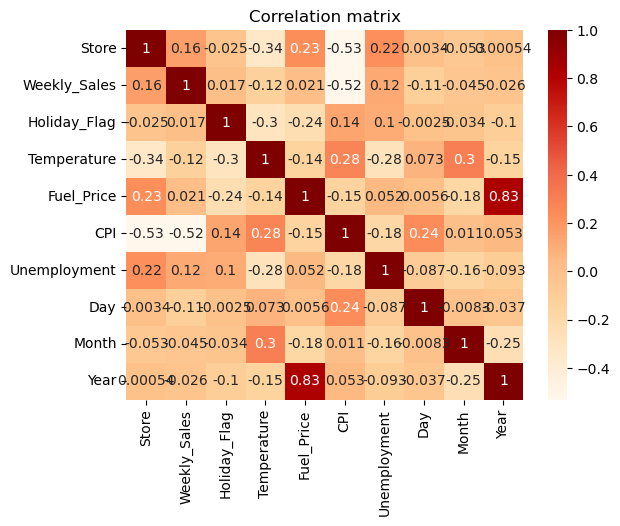

In [272]:
corr_ = data.corr(method='spearman')

sns.heatmap(corr_ , annot=True , cmap='OrRd')
plt.title('Correlation matrix')
plt.show()

From this graph, we see the most correlated variables with weekly sales are Store and CPI.

**Target variable/target (Y) that we will try to predict, to separate from the others** : *Weekly_Sales*

 **------------**

In [273]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "Weekly_Sales"

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]

print("...Done.")
print()

Separating labels from features...
...Done.



#### Preprocessings to be planned with scikit-learn

 **Explanatory variables (X)**
We need to identify which columns contain categorical variables and which columns contain numerical variables, as they will be treated differently.

 - Categorical variables : Store, Holiday_Flag
 - Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day, DayOfWeek

In [274]:
# First : always divide dataset into train set & test set !!
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=53)

print("...Done.")
print()


# Create pipeline for numeric features
numeric_features = ['Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'] # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Create pipeline for categorical features
categorical_features = ['Store','Holiday_Flag'] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing done")

Dividing into train and test sets...
...Done.

Preprocessing done


In [275]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test)
print('...Done.')


Performing preprocessings on train set...
...Done.
Performing preprocessings on test set...
...Done.


c:\Users\Celine\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



### Part 2 : Baseline model (linear regression)
We are going to train our first model, and assess its performances on the train and test sets.



In [276]:
regressor = LinearRegression() #permet de déclarer une instance de cette classe




In [277]:
# Train model
print("Train model...")
regressor.fit(X_train, Y_train)
print("...Done.")

# Print R^2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))

Train model...
...Done.
R2 score on training set :  0.9793055588560163
R2 score on test set :  0.9454262208116311


In [278]:
# Perform 5-fold cross-validation to evaluate the generalized R2 score obtained with a linear model
print("5-fold cross-validation...")
scores = cross_val_score(regressor, X_train, Y_train, cv=10)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

5-fold cross-validation...
The cross-validated R2-score is :  0.892906092885483
The standard deviation is :  0.09863093725226052


In [279]:
# Get feature names from preprocessing pipeline
num_names = preprocessor.transformers_[0][1][1].get_feature_names_out(numeric_features)
cat_names = preprocessor.transformers_[1][1][1].get_feature_names_out(categorical_features)

feature_names = np.concatenate([num_names, cat_names], axis=0)
feature_names

array(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Store_2.0',
       'Store_3.0', 'Store_4.0', 'Store_5.0', 'Store_6.0', 'Store_7.0',
       'Store_8.0', 'Store_9.0', 'Store_10.0', 'Store_11.0', 'Store_13.0',
       'Store_14.0', 'Store_15.0', 'Store_16.0', 'Store_17.0',
       'Store_18.0', 'Store_19.0', 'Store_20.0', 'Holiday_Flag_1.0'],
      dtype=object)

In [280]:
# Create a Dataframe with features and the coefficients associated
df_coef = pd.DataFrame(index = feature_names, data = regressor.coef_, columns=["linear_coefficients"])
df_coef['linear_abs_coefficients'] = abs(df_coef["linear_coefficients"])

In [281]:
df_coef.sort_values(by='linear_abs_coefficients', ascending=False).head()

,linear_coefficients,linear_abs_coefficients
Store_4.0,2.488618e+06,2.488618e+06
Store_10.0,2.226840e+06,2.226840e+06
Store_13.0,2.218558e+06,2.218558e+06
Store_19.0,1.566722e+06,1.566722e+06
Store_5.0,-1.386222e+06,1.386222e+06


In this supervised model, we can see that the weekly sales depend greatly on the store in itself.

In [282]:
#let's create a dataframe with the accuracy scores of the model
result = pd.DataFrame(columns=  ['model', 'accuracy', 'set'])
result.loc[len(result), result.columns] = 'LinearReg',  regressor.score(X_train, Y_train), 'train'
result.loc[len(result), result.columns] = 'LinearReg',  regressor.score(X_test, Y_test), 'test'
print(result)


       model  accuracy    set
0  LinearReg  0.979306  train
1  LinearReg  0.945426   test


### Part 3 : Fight overfitting
In this last part, we'll have to train a **regularized linear regression model**. 


1/ Regularized linear regression : Ridge

In [283]:
# Perform grid search
print("Grid search...")
ridge = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 5, 10] # 0 corresponds to no regularization
}
gridsearch_r = GridSearchCV(ridge, param_grid = params, cv = 5) 
gridsearch_r.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_r.best_params_)
print("Best R2 score : ", gridsearch_r.best_score_)



Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.1}
Best R2 score :  0.6676071665058863


In [284]:
# Print R^2 scores
print("R2 score on training set : ", gridsearch_r.score(X_train, Y_train))
print("R2 score on test set : ", gridsearch_r.score(X_test, Y_test))

R2 score on training set :  0.9736785650144023
R2 score on test set :  0.9530226207375918


In [285]:
#insert ridge model coef into coefficient dataframe
df_coef["ridge_coefficients"] = gridsearch_r.best_estimator_.coef_
df_coef['abs_ridge_coefficients'] = abs(df_coef["ridge_coefficients"])

In [286]:
#insert ridge model results into results dataframe
result.loc[len(result), result.columns] = 'Ridge',  gridsearch_r.score(X_train, Y_train), 'train'
result.loc[len(result), result.columns] = 'Ridge',  gridsearch_r.score(X_test, Y_test), 'test'

2/ Regularized linear regression : Lasso

In [287]:
# Perform grid search
print("Grid search...")
lasso = Lasso()
# Grid of values to be tested
params = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 3] # 0 corresponds to no regularization
}
gridsearch_l = GridSearchCV(lasso, param_grid = params, cv = 5) 
gridsearch_l.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_l.best_params_)
print("Best R2 score : ", gridsearch_l.best_score_)


Grid search...


c:\Users\Celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 235072336554.55667, tolerance: 2500576660.101181

c:\Users\Celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 243228449103.84372, tolerance: 2313108516.9572268

c:\Users\Celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 137113119135.50206, tolerance: 2172570771.5413337

c:\Users\Celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 221235951413.812

...Done.
Best hyperparameters :  {'alpha': 1e-05}
Best R2 score :  0.6985493587114172


c:\Users\Celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 234098464814.34406, tolerance: 2500576660.101181

c:\Users\Celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 240592857335.30655, tolerance: 2313108516.9572268

c:\Users\Celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 137305944041.47688, tolerance: 2172570771.5413337

c:\Users\Celine\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 211425844964.507

In [288]:
# Print R^2 scores
print("R2 score on training set : ", gridsearch_l.score(X_train, Y_train))
print("R2 score on test set : ", gridsearch_l.score(X_test, Y_test))


R2 score on training set :  0.9789013207657871
R2 score on test set :  0.9444150944210177


In [289]:
df_coef["lasso_coefficients"] = gridsearch_l.best_estimator_.coef_
df_coef['abs_lasso_coefficients'] = abs(df_coef["lasso_coefficients"])

In [290]:
result.loc[len(result), result.columns] = 'Lasso',  gridsearch_l.score(X_train, Y_train), 'train'
result.loc[len(result), result.columns] = 'Lasso',  gridsearch_l.score(X_test, Y_test), 'test'

# Conclusion
Let's compare the results stemming from the 3 models, and see which parameters influence most the weekly sales of Walmart stores.

In [293]:
result

,model,accuracy,set
0,LinearReg,0.979306,train
1,LinearReg,0.945426,test
2,Ridge,0.973679,train
3,Ridge,0.953023,test
4,Lasso,0.978901,train
5,Lasso,0.944415,test


In [291]:
out = result.sort_values(by=['set', 'accuracy'], ascending = [True, False])
px.bar(out, x = 'model', y= 'accuracy', color = 'set', barmode="group")

All three models give satisfying results. The ridge regression model gives slightly less overfitting than the two others, but it is not significant. All in all, regularization was not so necessary.

In [296]:
#coefficient importance
coef = df_coef.rename_axis('feature').reset_index()
coef_out = coef.melt(id_vars='feature', value_vars=[ 'linear_abs_coefficients','abs_ridge_coefficients', 'abs_lasso_coefficients'],
        var_name='model', value_name='coef_value')
coef_out = coef_out.sort_values(by='coef_value', ascending = False)
px.bar(coef_out, x = 'feature', y= 'coef_value', color = 'model', barmode="group")

As for the feature importance, it is clear that the most important features to estimate the weekly sales of Walmart are the stores in themselves. To a less extent, the CPI plays a role as well. 